## Modélisation Prédictive avec un Classificateur

### Informations sur le Projet

- **Auteur** : Fono Colince  
  
- **Lien vers les datasets** :  
  - [Dataset : Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv)


- **customerID** : Identifiant unique du client.
- **gender** : Sexe du client (par exemple, "Male" ou "Female").
- **SeniorCitizen** : Indique si le client est une personne âgée (1 pour Oui, 0 pour Non).
- **Partner** : Indique si le client a un conjoint ou un partenaire (Oui/Non).
- **Dependents** : Indique si le client a des personnes à charge (Oui/Non).
- **tenure** : Nombre de mois pendant lesquels le client est resté actif.
- **PhoneService** : Indique si le client utilise un service téléphonique (Oui/Non).
- **MultipleLines** : Indique si le client a plusieurs lignes téléphoniques (Oui/Non/Non applicable).
- **InternetService** : Type de service Internet utilisé par le client (par exemple, "DSL", "Fiber optic", ou "None").
- **OnlineSecurity** : Indique si le client a un service de sécurité en ligne (Oui/Non).
- **OnlineBackup** : Indique si le client utilise un service de sauvegarde en ligne (Oui/Non).
- **DeviceProtection** : Indique si le client a une protection pour ses appareils (Oui/Non).
- **TechSupport** : Indique si le client bénéficie d'une assistance technique (Oui/Non).
- **StreamingTV** : Indique si le client utilise un service de streaming TV (Oui/Non).
- **StreamingMovies** : Indique si le client utilise un service de streaming de films (Oui/Non).
- **Contract** : Type de contrat (par exemple, "Month-to-month", "One year", ou "Two year").
- **PaperlessBilling** : Indique si le client utilise la facturation sans papier (Oui/Non).
- **PaymentMethod** : Mode de paiement (par exemple, "Electronic check", "Mailed check", etc.).
- **MonthlyCharges** : Frais mensuels facturés au client.
- **TotalCharges** : Frais totaux accumulés par le client.
- **Churn** : Indique si le client a résilié son abonnement (Oui/Non).

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans



## Étape 1 : Chargement des données

In [124]:

def load_data(file_path: str):
    df = pd.read_csv(file_path)
    return df

## Étape 2 : Analyse exploratoire des données (EDA)

In [125]:
churn = pd.read_csv("../data/churn.csv")
profile = ProfileReport(churn, title="Rapport de Profiling", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [126]:

def perform_eda(df: pd.DataFrame):
    #print("Aperçu des données :\n", df.head())
    print("\nStatistiques descriptives :\n", df.describe())
    print("\nColonnes avec valeurs manquantes :\n", df.isnull().sum())

    # Visualisation des distributions des colonnes principales
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Churn')
    plt.title('Répartition du Churn')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.histplot(df['MonthlyCharges'], kde=True, bins=30, color='blue')
    plt.title('Distribution des frais mensuels')
    plt.show()

## Étape 3 : Prétraitement des données

In [127]:

def preprocess_data(df: pd.DataFrame):
    # Suppression des colonnes inutiles
    customerID = df['customerID']
    df.drop(['customerID'], axis=1, inplace=True)
    
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
    
    # Gestion des valeurs manquantes et  Encodage des colonnes catégoriques
    label_encoders = {}
    for column in df.columns:
            
            if df[column].isna().sum() > 0:  
                
                if pd.api.types.is_numeric_dtype(df[column]):  
                    df[column] = df[column].fillna(df[column].median()) 
                    
                elif pd.api.types.is_object_dtype(df[column]): 
                    df[column] = df[column].fillna(df[column].mode()[0]) 
                    
            
            # Encodage des colonnes catégoriques
            if pd.api.types.is_object_dtype(df[column]):       
                    le = LabelEncoder()
                    df[column] = le.fit_transform(df[column])
                    label_encoders[column] = le

    # Normalisation des colonnes numériques
    scaler = StandardScaler()
    numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df, label_encoders,customerID,scaler


## Étape 4 : Entraînement du modèle

In [128]:
def train_model(df: pd.DataFrame):
    
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42, n_estimators=150)
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Évaluation
    print("Rapport de classification :\n", classification_report(y_test, y_pred))
    print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred))

    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()
    plt.show()

    return model

## Étape 5 : Pipeline complet

In [129]:

def pipeline(file_path: str):
  
    data = load_data(file_path)

    # EDA
    perform_eda(data)

    # Prétraitement
    data, label_encoders,customerID,scaler = preprocess_data(data)

    # Entraînement du modèle
    model = train_model(data)

    return model, label_encoders,scaler, data,customerID


## Exemple d'utilisation


Statistiques descriptives :
        SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

Colonnes avec valeurs manquantes :
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


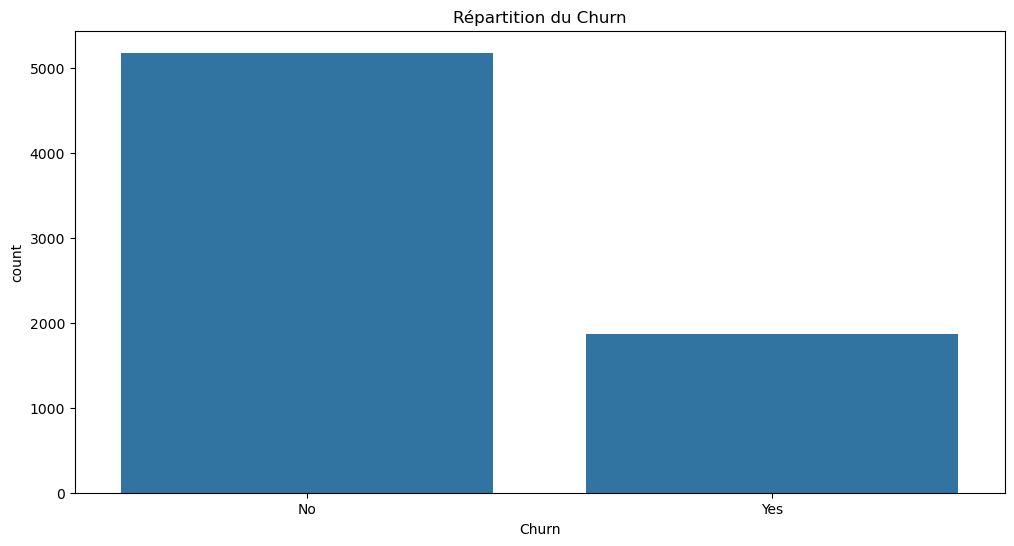

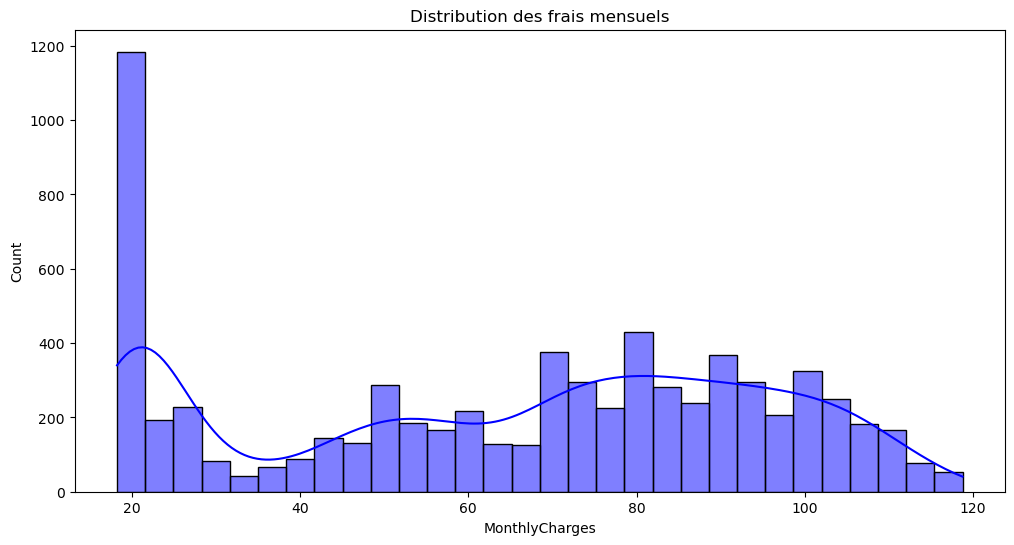

Rapport de classification :
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.67      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409


Matrice de confusion :
 [[948  88]
 [197 176]]


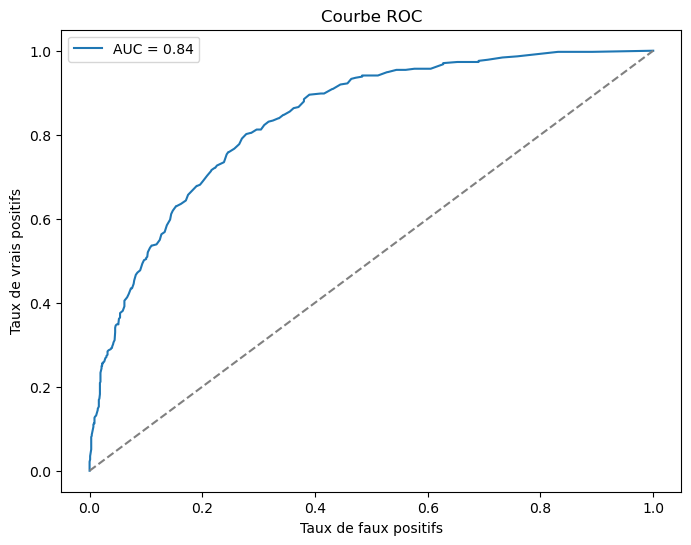

In [130]:
model, label_encoders,scaler, data,customerID = pipeline("../data/churn.csv")

In [131]:
data.head()

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.277445             0   
1       1              0        0           0  0.066327             1   
2       1              0        0           0 -1.236724             1   
3       1              0        0           0  0.514251             0   
4       0              0        0           0 -1.236724             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2       -1.160323     -0.994242      0  
1                 0              3       -0.259629     -0.173244      0  
2                 1              3       -0.362660     -0.959674      1  
3                 0              0       -0.746535     -0.194766      0  
4                 1              2        0.197365     -0.940470      1

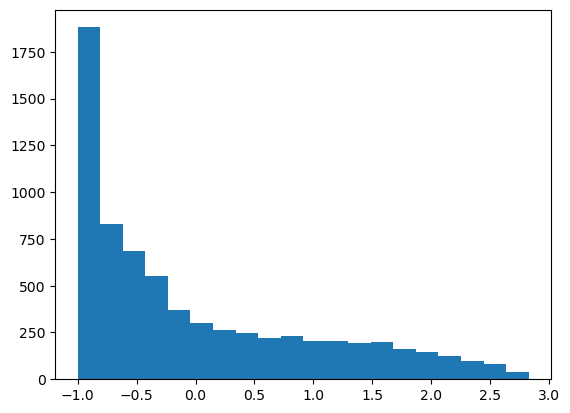

In [132]:
plt.hist(data['TotalCharges'],bins=20)
plt.show()

## Étape supplémentaire : Groupement naturel des clients

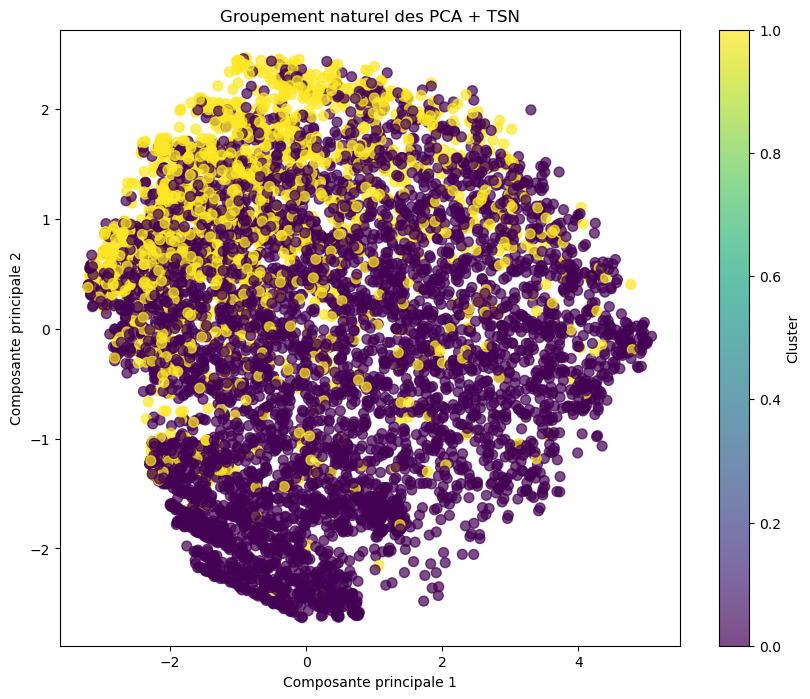

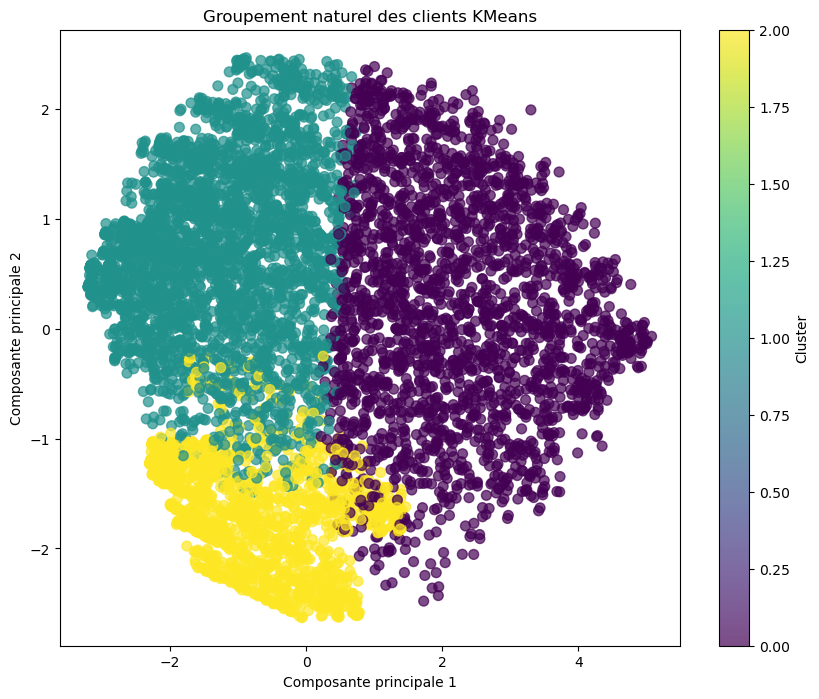

In [139]:
def groupementNatuelClient(df: pd.DataFrame):
    """Groupe de clients visualisé en 2D

    Args:
        df (pd.DataFrame): Données prétraitées
    """
    
    y = data['Churn'].to_numpy()
    df = data.drop('Churn',axis=1).to_numpy()
    
    # Réduction des dimensions avec PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(df)
    
    #tsne = TSNE(n_components=2, random_state=42)
    #X_tsn = tsne.fit_transform(reduced_data)

    # Application de KMeans pour le clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(df)

    # Visualisation des clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, s=50, alpha=0.7)
    plt.title('Groupement naturel des PCA + TSN')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.colorbar(label='Cluster')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, s=50, alpha=0.7)
    plt.title('Groupement naturel des clients KMeans')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.colorbar(label='Cluster')
    plt.show()
    
    return clusters
    
clusters = groupementNatuelClient(data)

## Analyse des clusters :

- Étudier les caractéristiques des clients dans chaque cluster pour comprendre leurs comportements.
- Par exemple, calculer les moyennes ou médianes des variables clés dans chaque cluster.

In [140]:
def clustersAnalyse(path : str,clusters):
    
    data = load_data(path)

    data.drop(['customerID'],axis=1,inplace=True)
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data['Cluster'] = clusters
    
    return data

dataclusters = clustersAnalyse('../data/churn.csv',clusters=clusters)


In [142]:
cluster_summary = dataclusters.groupby('Cluster')
print(cluster_summary.describe())

        SeniorCitizen                                               tenure  \
                count      mean       std  min  25%  50%  75%  max   count   
Cluster                                                                      
0              2342.0  0.199402  0.399636  0.0  0.0  0.0  0.0  1.0  2342.0   
1              3093.0  0.200776  0.400646  0.0  0.0  0.0  0.0  1.0  3093.0   
2              1608.0  0.033582  0.180207  0.0  0.0  0.0  0.0  1.0  1608.0   

                    ... MonthlyCharges         TotalCharges               \
              mean  ...            75%     max        count         mean   
Cluster             ...                                                    
0        55.830914  ...         104.20  118.75       2342.0  4983.336998   
1        15.525057  ...          84.30  107.95       3091.0  1051.966775   
2        30.606343  ...          23.95   80.85       1599.0   708.920669   

                                                                    
     

In [147]:
data['Cluster'] = clusters
churn_rate_by_cluster = data.groupby('Cluster')['Churn'].mean()
print("Taux de churn par cluster :")
print(churn_rate_by_cluster)

Taux de churn par cluster :
Cluster
0    0.154996
1    0.449725
2    0.071517
Name: Churn, dtype: float64


In [150]:
dataclusters['Cluster'].value_counts()

Cluster
1    3093
0    2342
2    1608
Name: count, dtype: int64

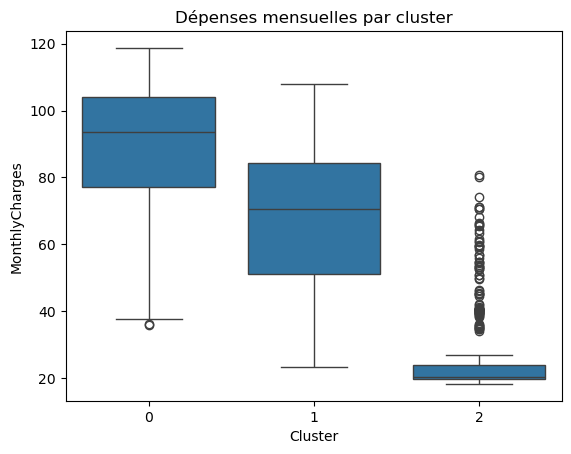

In [151]:
sns.boxplot(data=dataclusters, x='Cluster', y='MonthlyCharges')
plt.title("Dépenses mensuelles par cluster")
plt.show()


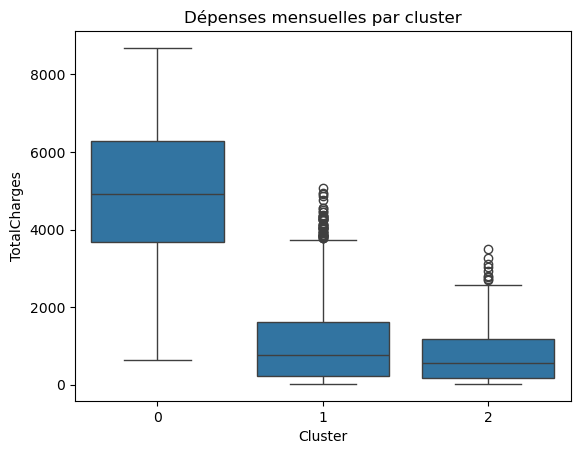

In [152]:
sns.boxplot(data=dataclusters, x='Cluster', y='TotalCharges')
plt.title("Dépenses mensuelles par cluster")
plt.show()

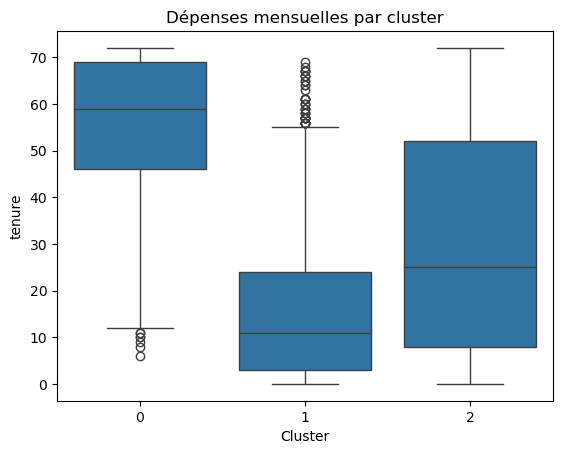

In [153]:
sns.boxplot(data=dataclusters, x='Cluster', y='tenure')
plt.title("Dépenses mensuelles par cluster")
plt.show()

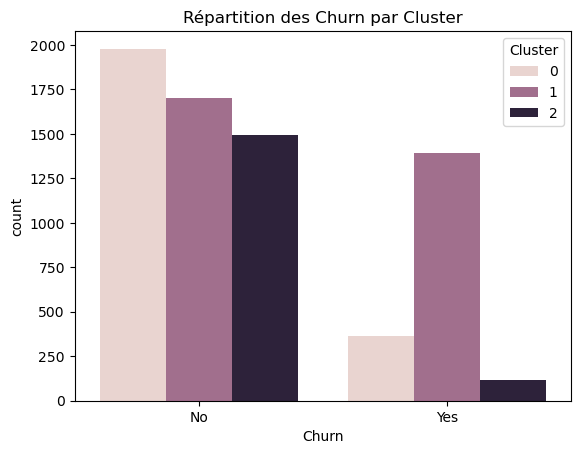

In [154]:
sns.countplot(x='Churn', hue='Cluster', data=dataclusters)
plt.title('Répartition des Churn par Cluster')
plt.show()

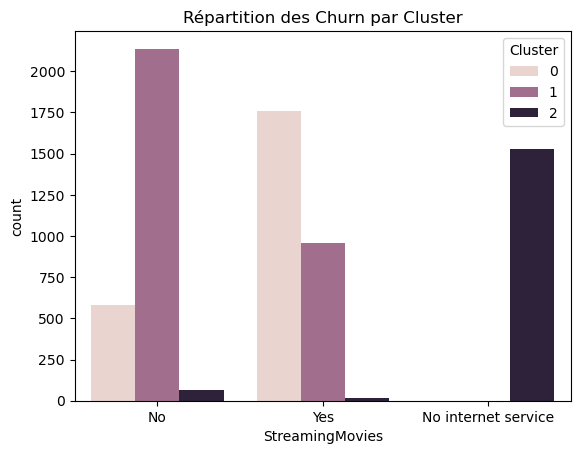

In [155]:
sns.countplot(x='StreamingMovies', hue='Cluster', data=dataclusters)
plt.title('Répartition des Churn par Cluster')
plt.show()

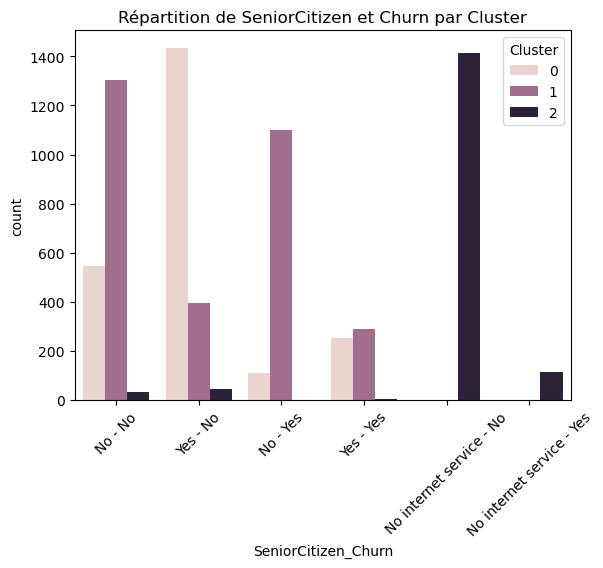

In [156]:

dataclusters['SeniorCitizen_Churn'] = dataclusters['DeviceProtection'].astype(str) + ' - ' + dataclusters['Churn'].astype(str)


sns.countplot(x='SeniorCitizen_Churn', hue='Cluster', data=dataclusters)
plt.title('Répartition de SeniorCitizen et Churn par Cluster')
plt.xticks(rotation=45) 
plt.show()


In [157]:
dataclusters.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'Cluster',
       'SeniorCitizen_Churn'],
      dtype='object')